## Monthly based RFM

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np


In [3]:
rfm_all = pd.read_csv('data/data-trans/final_rfm_monthly.csv', low_memory=False)

In [4]:
# remove outlier
rfm_all = rfm_all[rfm_all['bid']!=49880]


In [5]:
rfm_all

,bid,recency_t,frequency_t,monetary_t,recency_ec,frequency_ec,monetary_ec,recency_fc,frequency_fc,monetary_fc
0,3551.0,NaN,NaN,NaN,30.0,5.0,52425.0,NaN,NaN,NaN
1,3552.0,NaN,NaN,NaN,30.0,23.0,283125.0,NaN,NaN,NaN
2,3553.0,10.0,6.0,39600.0,37.0,11.0,63395.0,48.0,2.0,6540.0
3,3554.0,17.0,7.0,9000.0,38.0,2.0,7306.0,NaN,NaN,NaN
4,3555.0,NaN,NaN,NaN,5.0,7.0,19805.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
123165,161739.0,22.0,1.0,3500.0,NaN,NaN,NaN,NaN,NaN,NaN
123166,161740.0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
123167,161741.0,4.0,2.0,7800.0,NaN,NaN,NaN,NaN,NaN,NaN
123168,161742.0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
colors = sns.color_palette("tab10")

### RFM preprocessing & standardization

In [7]:
# handle null
# recency = 61
# monetary & frequency = 0
fill_value = {'recency_fc':61, 'recency_ec':61, 'recency_t':61, 'frequency_fc':0,'frequency_ec':0,'frequency_t':0,'monetary_fc':0,'monetary_ec':0,'monetary_t':0}
rfm_filled = rfm_all.fillna(fill_value)


In [8]:
rfm_fc = rfm_filled[['bid','recency_fc','frequency_fc','monetary_fc']]
rfm_t = rfm_filled[['bid','recency_t','frequency_t','monetary_t']]
rfm_ec = rfm_filled[['bid','recency_ec','frequency_ec','monetary_ec']]

In [9]:
# rfm_filled.sample(n=10)
rfm_filled.head()

,bid,recency_t,frequency_t,monetary_t,recency_ec,frequency_ec,monetary_ec,recency_fc,frequency_fc,monetary_fc
0,3551.0,61.0,0.0,0.0,30.0,5.0,52425.0,61.0,0.0,0.0
1,3552.0,61.0,0.0,0.0,30.0,23.0,283125.0,61.0,0.0,0.0
2,3553.0,10.0,6.0,39600.0,37.0,11.0,63395.0,48.0,2.0,6540.0
3,3554.0,17.0,7.0,9000.0,38.0,2.0,7306.0,61.0,0.0,0.0
4,3555.0,61.0,0.0,0.0,5.0,7.0,19805.0,61.0,0.0,0.0


In [10]:
minmax_scaler = MinMaxScaler()
log_scaler = FunctionTransformer(np.log1p, validate=True)


In [11]:
rfm_filled_scale = rfm_filled.copy()
rfm_fc_scale = rfm_fc.copy()
rfm_ec_scale = rfm_ec.copy()
rfm_t_scale = rfm_t.copy()

# minmax scale for recency and frequency; log scale for monetary
rfm_fc_scale[['recency_fc','frequency_fc']] = minmax_scaler.fit_transform(rfm_fc[['recency_fc','frequency_fc']])
rfm_fc_scale[['monetary_fc']] = log_scaler.fit_transform(rfm_fc[['monetary_fc']])

rfm_ec_scale[['recency_ec','frequency_ec']] = minmax_scaler.fit_transform(rfm_ec[['recency_ec','frequency_ec']])
rfm_ec_scale[['monetary_ec']] = log_scaler.fit_transform(rfm_ec[['monetary_ec']])

rfm_t_scale[['recency_t','frequency_t']] = minmax_scaler.fit_transform(rfm_t[['recency_t','frequency_t']])
rfm_t_scale[['monetary_t']] = log_scaler.fit_transform(rfm_t[['monetary_t']])

In [27]:
rfm_fc_scale.head()

,bid,recency_fc,frequency_fc,monetary_fc
0,3551.0,1.000000,0.000000,0.000000
1,3552.0,1.000000,0.000000,0.000000
2,3553.0,0.779661,0.333333,8.785845
3,3554.0,1.000000,0.000000,0.000000
4,3555.0,1.000000,0.000000,0.000000


### Modeling

#### Functions

##### silhouette scores and inertia

In [12]:
def inertia(df, category):
    # Determine the optimal number of clusters using the elbow method
    inertia = []
    silhouette_scores = []
    K = range(2, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df[[f'recency_{category}',f'frequency_{category}',f'monetary_{category}']])
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(df[[f'recency_{category}',f'frequency_{category}',f'monetary_{category}']], kmeans.labels_))

    # Create subplots with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot the elbow curve
    ax1.plot(K, inertia, 'bo-')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Inertia')
    ax1.set_title(f'Elbow Method For Optimal k (RFM-{category})')

    # Plot the silhouette scores
    ax2.plot(K, silhouette_scores, 'bo-')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title(f'Silhouette Method For Optimal k (RFM-{category})')

    plt.suptitle((f"Inertia and silhouette scores (RFM-{category})"),
                fontsize=14, fontweight='bold')
                
    # Adjust layout
    plt.tight_layout()
    plt.show()


##### Drawing silhouette graph


In [13]:

def drawing_graph(num_optimal, df, category):
    # Data (replace with your actual data)
    # rfm_fc should be your DataFrame containing the features ['recency_fc', 'frequency_fc', 'monetary_fc', 'average_purchase_fc']

    # Number of clusters (replace with the optimal number of clusters you found)
    optimal_clusters = num_optimal

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The silhouette coefficient can range from -1, 1 but in practice, will be between -0.1 and 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters
    ax1.set_ylim([0, len(df) + (optimal_clusters + 1) * 10])

    # Initialize the clusterer with optimal number of clusters and a random generator seed for reproducibility
    clusterer = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(df[[f'recency_{category}',f'frequency_{category}',f'monetary_{category}']])

    # The silhouette_score gives the average value for all the samples
    silhouette_avg = silhouette_score(df[[f'recency_{category}',f'frequency_{category}',f'monetary_{category}']], cluster_labels)
    print(f"For n_clusters = {optimal_clusters}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df[[f'recency_{category}',f'frequency_{category}',f'monetary_{category}']], cluster_labels)

    # Generate the cubehelix color palette
    # colors = sns.cubehelix_palette(optimal_clusters, start=0.5, rot=-0.75, dark=0.3, light=0.7, reverse=True)
    colors = sns.color_palette("tab10")


    y_lower = 10
    # colors = sns.color_palette('Set2', optimal_clusters)
    for i in range(optimal_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # color = cm.nipy_spectral(float(i) / optimal_clusters)
        color = colors[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers in the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

    # 2nd Plot showing the actual clusters formed
    # colors = cm.nipy_spectral(cluster_labels.astype(float) / optimal_clusters)
    # ax2.scatter(df[f'recency_{category}'], df[f'monetary_{category}'], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    ax2.scatter(df[f'recency_{category}'], df[f'monetary_{category}'], marker='.', s=30, lw=0, alpha=0.7, c=[colors[label] for label in cluster_labels], edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature - recency")
    ax2.set_ylabel("Feature space for the 2nd feature - monetary")

    plt.suptitle((f"Silhouette analysis for KMeans clustering on sample data with k_clusters = %d (RFM-{category})" % optimal_clusters),
                fontsize=14, fontweight='bold')

    plt.show()

    return cluster_labels


##### Kmeans FC

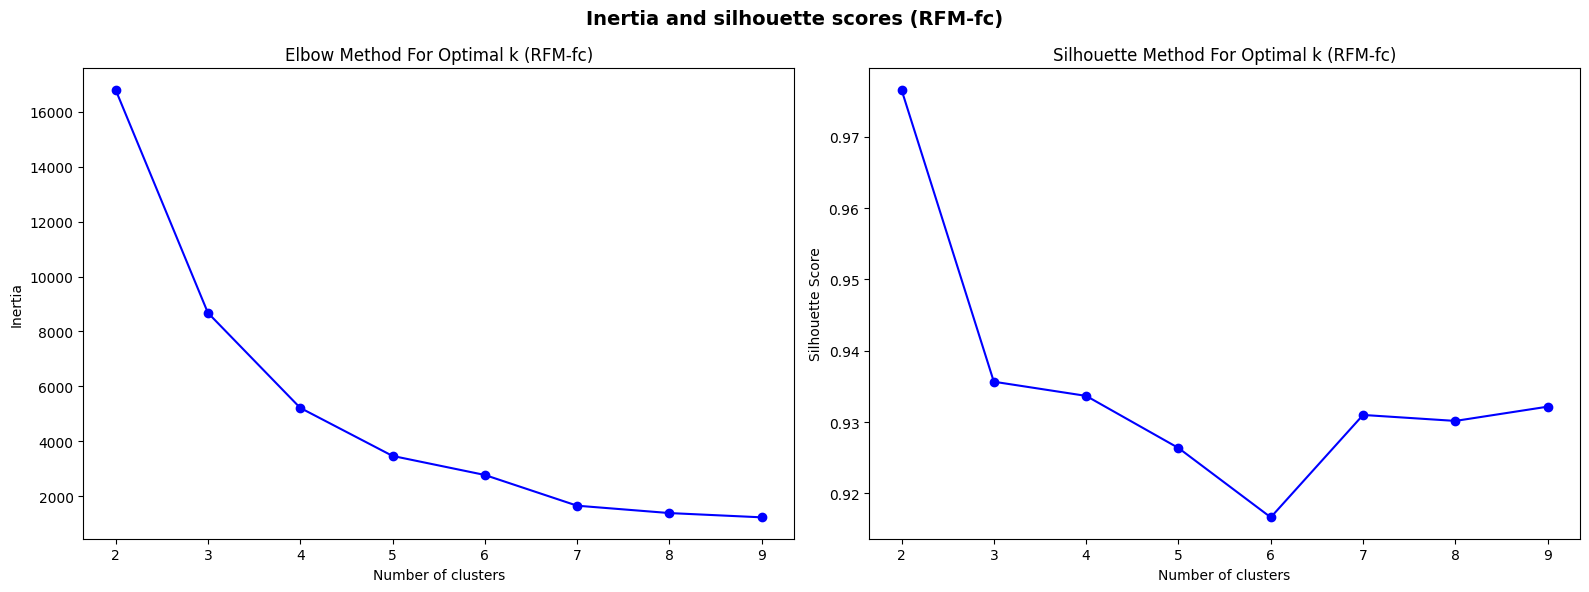

In [14]:
inertia(rfm_fc_scale, 'fc')

For n_clusters = 4, the average silhouette_score is : 0.933675698978819


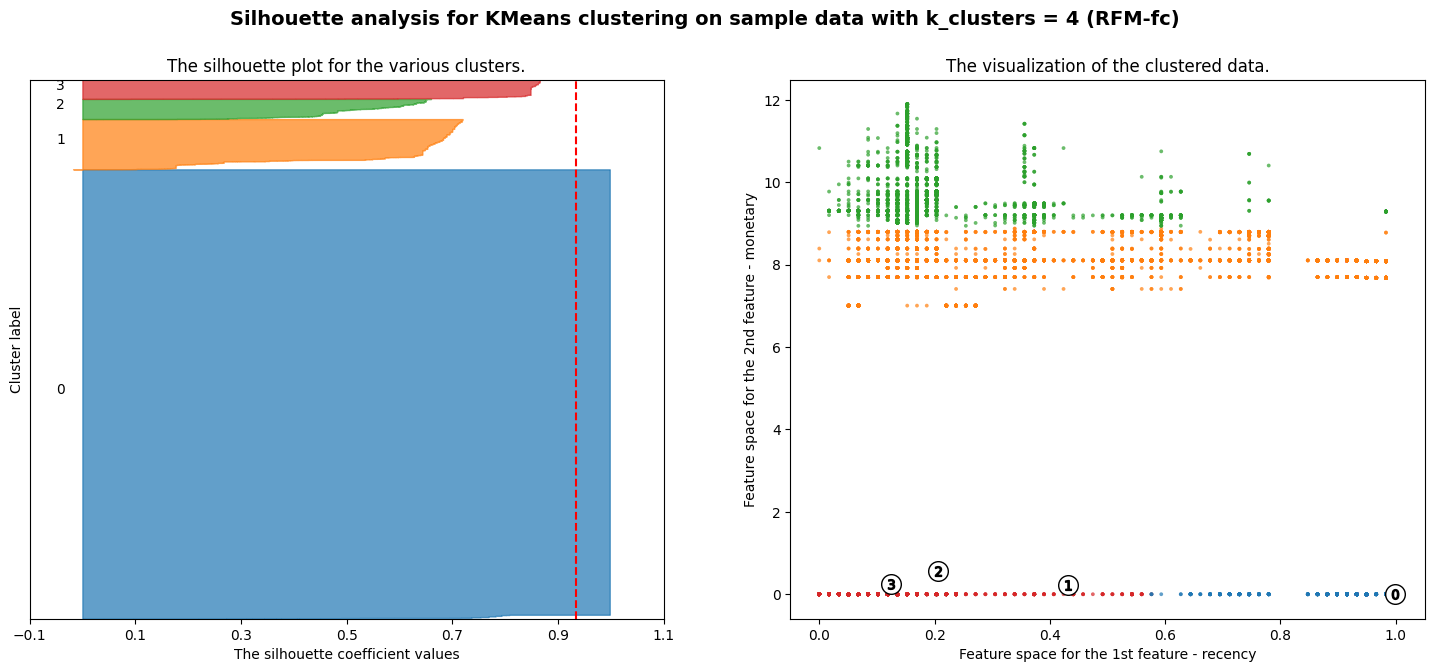

In [ ]:
k=4
cluster_labels = drawing_graph(k, rfm_fc_scale, 'fc')

In [22]:
# Assuming the optimal number of clusters is determined to be 5
# kmeans = KMeans(n_clusters=5, random_state=42)
rfm_fc['cluster_fc'] = cluster_labels
rfm_fc_scale['cluster_fc'] = rfm_fc['cluster_fc']
rfm_filled['cluster_fc'] = rfm_fc['cluster_fc']

# Analyze clusters, e.g., calculate mean RFM values for each cluster
cluster_analysis = rfm_fc.groupby('cluster_fc').mean()

# Print cluster analysis results
print(cluster_analysis)

                      bid  recency_fc  frequency_fc   monetary_fc
cluster_fc                                                       
0           107523.617146   60.941344      0.009278      0.000000
1            46599.674623   27.497691      1.275285   3717.734123
2            32982.842391   14.120870      3.326304  20483.528261
3            67111.183440    9.353614      1.490165      0.000000


C:\Users\seoye\AppData\Local\Temp\ipykernel_22264\3906462177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_fc['cluster_fc'] = cluster_labels


c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  func(x=x, y=y, **kwargs)
c:\Users\seoye\Desktop\seoyeong\N

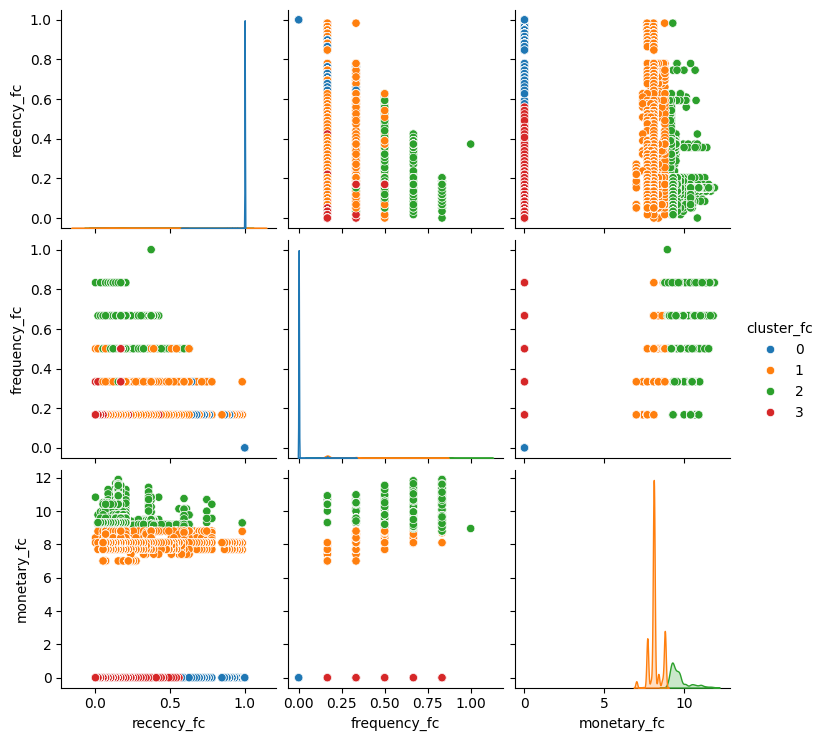

In [23]:
# Generate the cubehelix color palette
# colors = sns.cubehelix_palette(k, start=0.5, rot=-0.75, dark=0.3, light=0.7, reverse=True, as_cmap=False)

# Visualize clusters
sns.pairplot(rfm_fc_scale, hue='cluster_fc', vars=['recency_fc', 'frequency_fc', 'monetary_fc'], palette=colors)
plt.show()

In [24]:
rfm_fc

,bid,recency_fc,frequency_fc,monetary_fc,cluster_fc
0,3551.0,61.0,0.0,0.0,0
1,3552.0,61.0,0.0,0.0,0
2,3553.0,48.0,2.0,6540.0,1
3,3554.0,61.0,0.0,0.0,0
4,3555.0,61.0,0.0,0.0,0
...,...,...,...,...,...
123165,161739.0,61.0,0.0,0.0,0
123166,161740.0,61.0,0.0,0.0,0
123167,161741.0,61.0,0.0,0.0,0
123168,161742.0,61.0,0.0,0.0,0


In [25]:
rfm_fc['cluster_fc'].value_counts()

cluster_fc
0    102718
1     11479
2      4600
3      4372
Name: count, dtype: int64

##### Kmeans ec

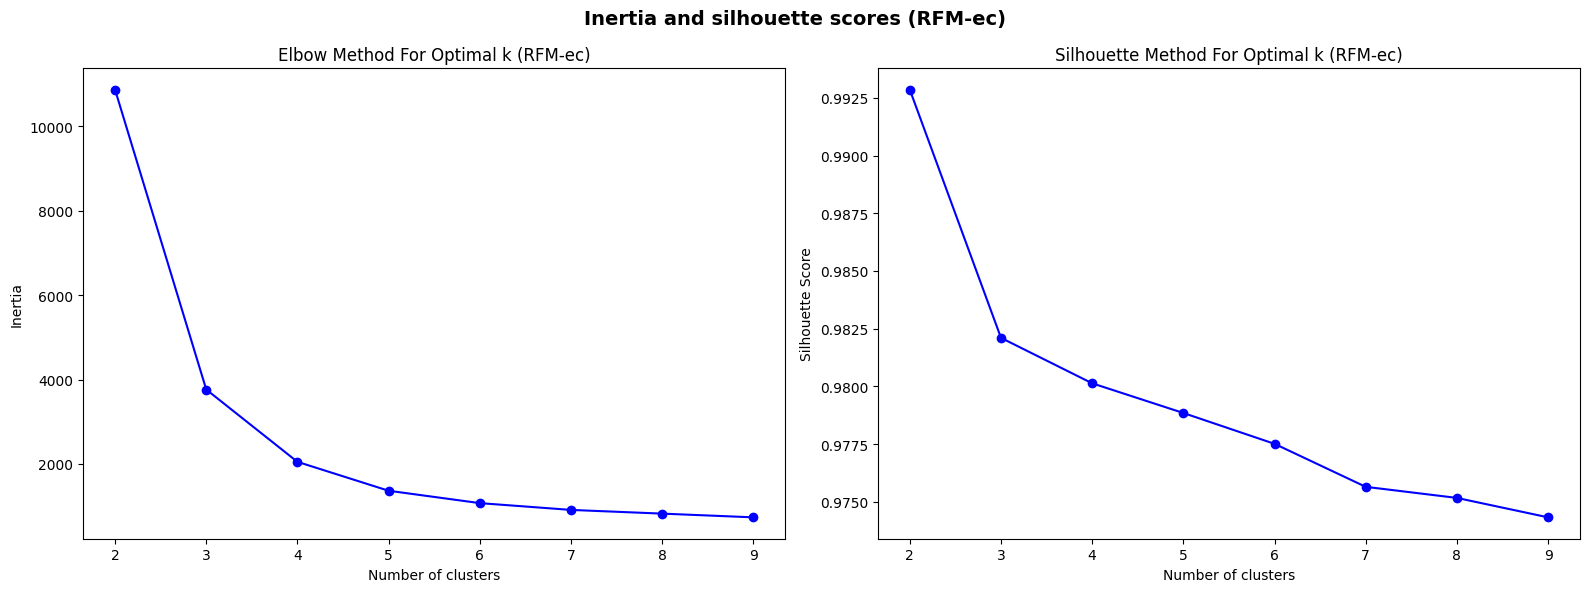

In [15]:
inertia(rfm_ec_scale, 'ec')

For n_clusters = 5, the average silhouette_score is : 0.9788458343747152


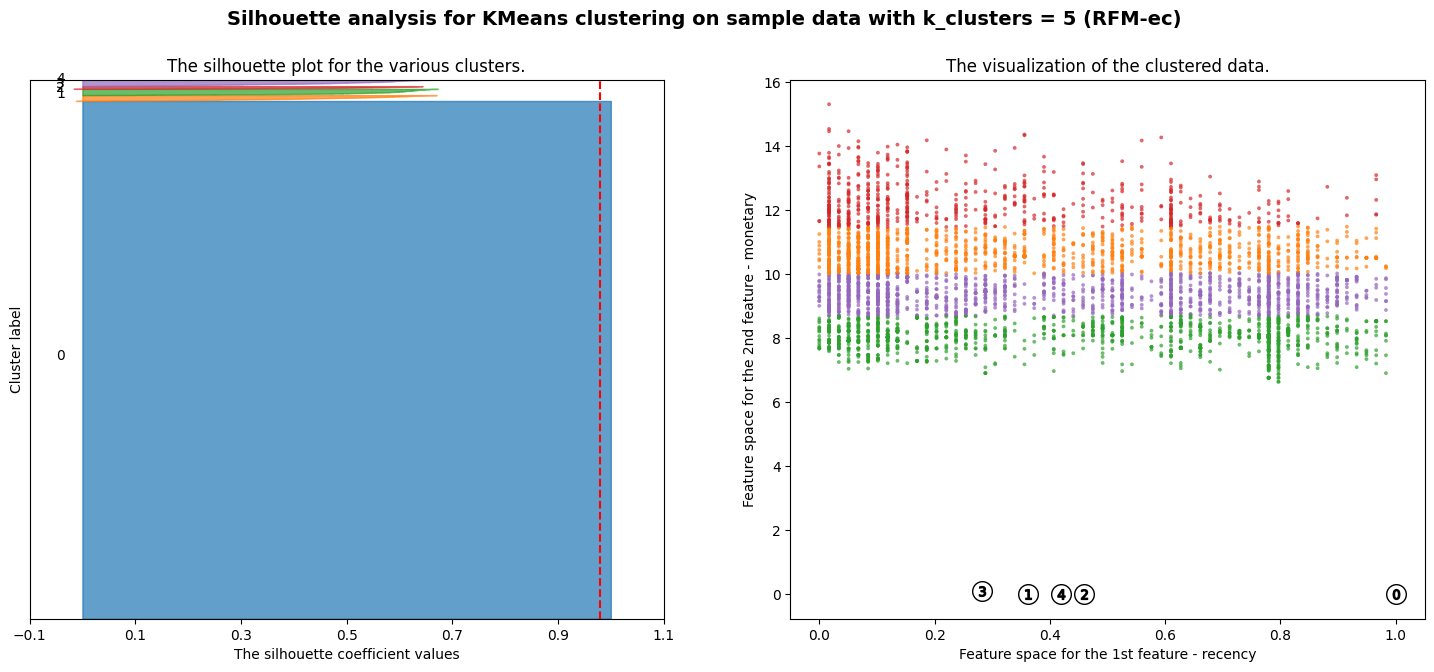

In [26]:
k=5
cluster_labels = drawing_graph(k, rfm_ec_scale, 'ec')


In [27]:
# Assuming the optimal number of clusters is determined to be 5
# kmeans = KMeans(n_clusters=5, random_state=42)
rfm_ec['cluster_ec'] = cluster_labels
rfm_ec_scale['cluster_ec'] = rfm_ec['cluster_ec']
rfm_filled['cluster_ec'] = rfm_ec['cluster_ec']

# Analyze clusters, e.g., calculate mean RFM values for each cluster
cluster_analysis = rfm_ec.groupby('cluster_ec').mean()

# Print cluster analysis results
print(cluster_analysis)

                      bid  recency_ec  frequency_ec    monetary_ec
cluster_ec                                                        
0           101117.382638   61.000000      0.000000       0.000000
1             9435.176426   23.266517      5.036036   46645.587838
2            15581.446416   29.097232      1.122072    3350.207949
3             6122.003221   18.623188     21.410628  293559.718196
4            12496.651002   26.802350      2.297167   12646.918452


C:\Users\seoye\AppData\Local\Temp\ipykernel_22264\3331148167.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_ec['cluster_ec'] = cluster_labels


c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  func(x=x, y=y, **kwargs)
c:\Users\seoye\Desktop\seoyeong\N

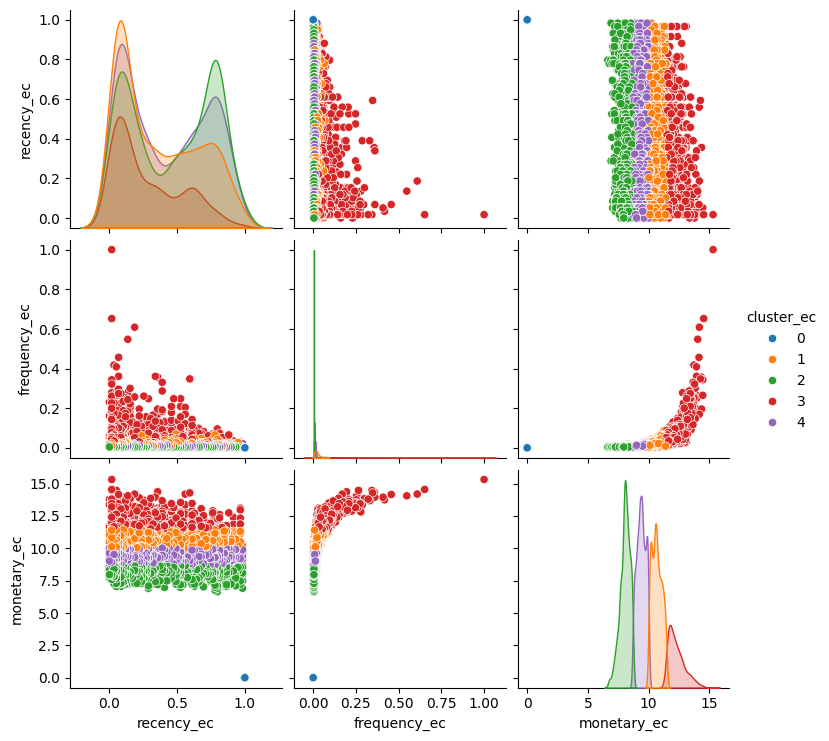

In [28]:
# Generate the cubehelix color palette
# colors = sns.cubehelix_palette(k, start=0.5, rot=-0.75, dark=0.3, light=0.7, reverse=True, as_cmap=False)

# Visualize clusters
sns.pairplot(rfm_ec_scale, hue='cluster_ec', vars=['recency_ec', 'frequency_ec', 'monetary_ec'], palette=colors)
plt.show()

In [29]:
rfm_ec

,bid,recency_ec,frequency_ec,monetary_ec,cluster_ec
0,3551.0,30.0,5.0,52425.0,1
1,3552.0,30.0,23.0,283125.0,3
2,3553.0,37.0,11.0,63395.0,1
3,3554.0,38.0,2.0,7306.0,4
4,3555.0,5.0,7.0,19805.0,4
...,...,...,...,...,...
123165,161739.0,61.0,0.0,0.0,0
123166,161740.0,61.0,0.0,0.0,0
123167,161741.0,61.0,0.0,0.0,0
123168,161742.0,61.0,0.0,0.0,0


In [30]:
rfm_ec['cluster_ec'].value_counts()

cluster_ec
0    118360
4      1447
2      1409
1      1332
3       621
Name: count, dtype: int64

##### Kmeans t

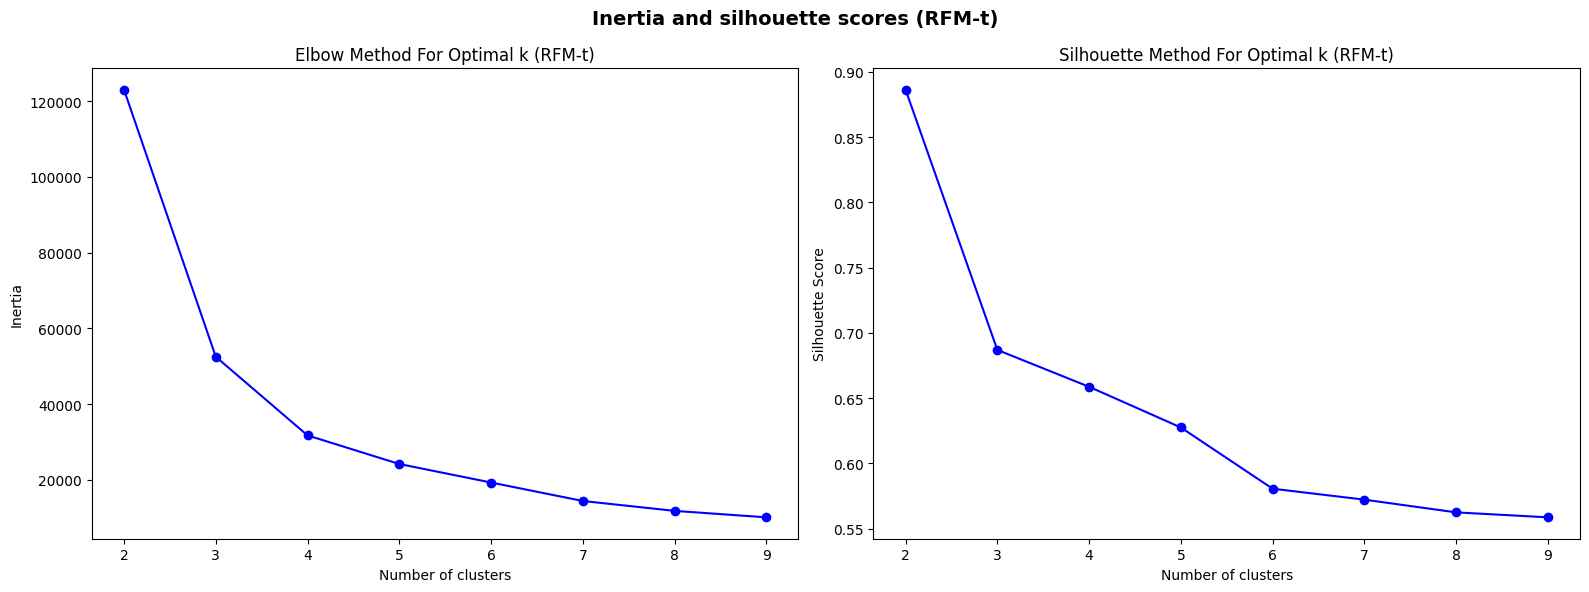

In [16]:
inertia(rfm_t_scale, 't')

For n_clusters = 5, the average silhouette_score is : 0.6275048100514963


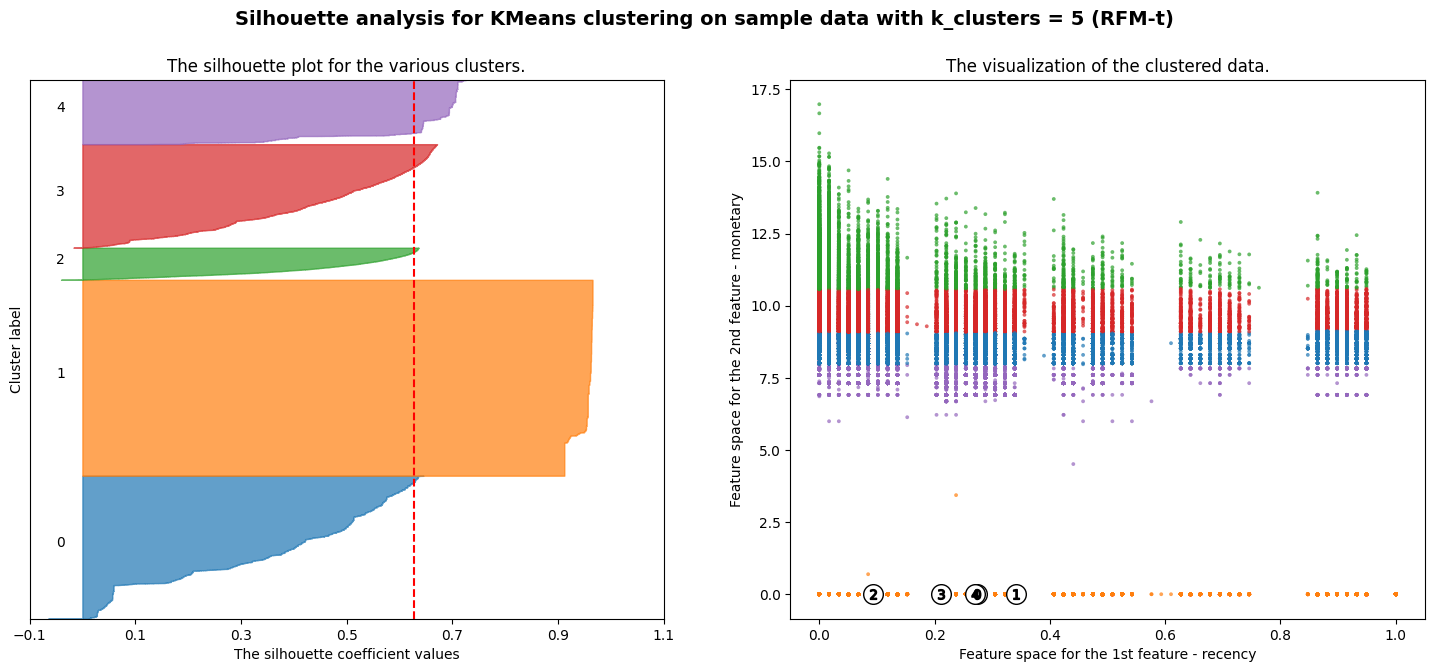

In [36]:
k=5
cluster_labels = drawing_graph(k, rfm_t_scale, 't')

In [37]:
# Assuming the optimal number of clusters is determined to be 5
# kmeans = KMeans(n_clusters=5, random_state=42)
rfm_t['cluster_t'] = cluster_labels
rfm_t_scale['cluster_t'] = rfm_t['cluster_t']
rfm_filled['cluster_t'] = rfm_t['cluster_t']

# Analyze clusters, e.g., calculate mean RFM values for each cluster
cluster_analysis = rfm_t.groupby('cluster_t').mean()

# Print cluster analysis results
print(cluster_analysis)

                     bid  recency_t  frequency_t     monetary_t
cluster_t                                                      
0          103101.706343  18.213549     3.466479    5122.053089
1          101118.438308  22.121307     2.453293       0.000692
2           55763.291678   7.496999    33.584993  161674.065757
3           91814.780356  14.381091     6.014539   17340.951819
4          105043.883680  17.979277     3.018005    1786.718304


C:\Users\seoye\AppData\Local\Temp\ipykernel_22264\806020569.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_t['cluster_t'] = cluster_labels


c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\seoye\Desktop\seoyeong\NCSU\Nagoya\nagoya-research\nagoya-venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  func(x=x, y=y, **kwargs)
c:\Users\seoye\Desktop\seoyeong\N

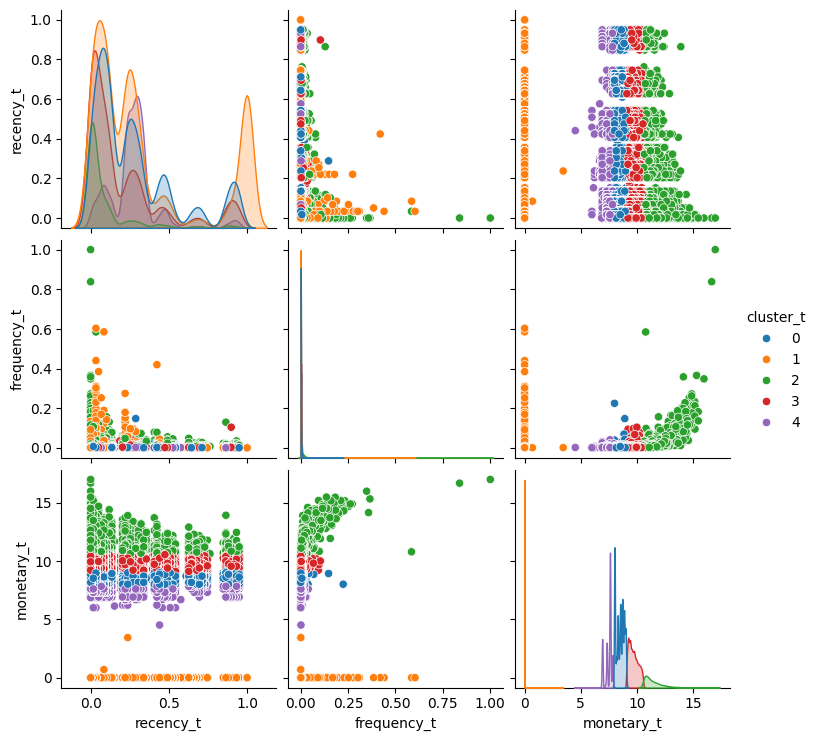

In [38]:
# Generate the cubehelix color palette
# colors = sns.cubehelix_palette(k, start=0.5, rot=-0.75, dark=0.3, light=0.7, reverse=True, as_cmap=False)

# Visualize clusters
sns.pairplot(rfm_t_scale, hue='cluster_t', vars=['recency_t', 'frequency_t', 'monetary_t'], palette=colors)
plt.show()

In [39]:
rfm_t

,bid,recency_t,frequency_t,monetary_t,cluster_t
0,3551.0,61.0,0.0,0.0,1
1,3552.0,61.0,0.0,0.0,1
2,3553.0,10.0,6.0,39600.0,2
3,3554.0,17.0,7.0,9000.0,3
4,3555.0,61.0,0.0,0.0,1
...,...,...,...,...,...
123165,161739.0,22.0,1.0,3500.0,0
123166,161740.0,2.0,2.0,0.0,1
123167,161741.0,4.0,2.0,7800.0,0
123168,161742.0,2.0,2.0,0.0,1


In [40]:
rfm_t['cluster_t'].value_counts()

cluster_t
1    44779
0    32681
3    23661
4    14718
2     7330
Name: count, dtype: int64

In [41]:
rfm_filled

,bid,recency_t,frequency_t,monetary_t,recency_ec,frequency_ec,monetary_ec,recency_fc,frequency_fc,monetary_fc,cluster_fc,cluster_ec,cluster_t
0,3551.0,61.0,0.0,0.0,30.0,5.0,52425.0,61.0,0.0,0.0,0,1,1
1,3552.0,61.0,0.0,0.0,30.0,23.0,283125.0,61.0,0.0,0.0,0,3,1
2,3553.0,10.0,6.0,39600.0,37.0,11.0,63395.0,48.0,2.0,6540.0,1,1,2
3,3554.0,17.0,7.0,9000.0,38.0,2.0,7306.0,61.0,0.0,0.0,0,4,3
4,3555.0,61.0,0.0,0.0,5.0,7.0,19805.0,61.0,0.0,0.0,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123165,161739.0,22.0,1.0,3500.0,61.0,0.0,0.0,61.0,0.0,0.0,0,0,0
123166,161740.0,2.0,2.0,0.0,61.0,0.0,0.0,61.0,0.0,0.0,0,0,1
123167,161741.0,4.0,2.0,7800.0,61.0,0.0,0.0,61.0,0.0,0.0,0,0,0
123168,161742.0,2.0,2.0,0.0,61.0,0.0,0.0,61.0,0.0,0.0,0,0,1


In [42]:
# save all data
rfm_filled.to_csv('data/data-trans/classification_rfm_monthly.csv', index=False)

### Train/Test

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
rfm_filled = pd.read_csv('data/data-trans/classification_rfm_monthly.csv', low_memory=False)

In [3]:

# Data
X = rfm_filled[['recency_fc', 'frequency_fc', 'monetary_fc', 'recency_ec', 'frequency_ec', 'monetary_ec', 'recency_t', 'frequency_t', 'monetary_t']]
y = rfm_filled[['cluster_fc', 'cluster_ec', 'cluster_t']]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Classification

In [4]:
# Function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, labels):
    fig, axes = plt.subplots(1, len(labels), figsize=(20, 5))
    for i, label in enumerate(labels):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
        axes[i].set_title(f'Confusion Matrix: {label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    plt.show()

In [ ]:
def model_training(model_name, model):
    model_name = model_name
    model = MultiOutputClassifier(model)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate each output separately
    precision, recall, f1 = {}, {}, {}
    for i, column in enumerate(y.columns):
        p, r, f, _ = precision_recall_fscore_support(y_test[column], y_pred[:, i], average='macro')
        precision[column] = p
        recall[column] = r
        f1[column] = f

    subset_accuracy = (y_test == y_pred).all(axis=1).mean()
    print(f"Model: {model_name}")
    print(f"Subset Accuracy: {subset_accuracy}")

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")

    print("\n"+"-"*60+"\n")

    # Accuracy for each cluster
    accuracy_fc = accuracy_score(y_test['cluster_fc'], y_pred[:, 0])
    accuracy_ec = accuracy_score(y_test['cluster_ec'], y_pred[:, 1])
    accuracy_t = accuracy_score(y_test['cluster_t'], y_pred[:, 2])
    print(f'Accuracy for cluster_fc: {accuracy_fc}')
    print(f'Accuracy for cluster_ec: {accuracy_ec}')
    print(f'Accuracy for cluster_t: {accuracy_t}')

    print("\n"+"-"*60+"\n")

    # Classification report for each output
    for i, column in enumerate(y.columns):
        print(f"Classification Report for {column}:")
        print(classification_report(y_test[column], y_pred[:, i], zero_division=0))


    # Plot confusion matrix
    plot_confusion_matrix(y_test.to_numpy(), y_pred, y.columns)


    print("\n" + "#"*60 + "\n")

##### logistic regression

In [ ]:
model_training('Logistic regression', LogisticRegression(max_iter=1000000, solver='lbfgs'))

##### Random forest

In [1]:
model_training('Random forest', RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=5, min_samples_leaf=5))

##### XGBoost

In [2]:
model_training('XGBoost', XGBClassifier(eval_metric='mlogloss', eta=0.01, n_estimators=100, max_depth=5, min_child_weight=5))

##### Gradient boosting

In [7]:
model_training('Gradient boosting', GradientBoostingClassifier(n_estimators=10, max_depth=3, min_samples_split=3, min_samples_leaf=3))

##### SVM

In [6]:
model_training('SVM', SVC(probability=True))

##### KNN

In [8]:
model_training('KNN', KNeighborsClassifier(n_neighbors=5))

##### Decision tree

In [9]:
model_training('Decision tree',DecisionTreeClassifier(max_depth=3, min_samples_split=3, min_samples_leaf=3))